In [39]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random

# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential, Model
# from keras.layers import (
#     Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
#     GlobalAveragePooling2D
# )
# from keras.optimizers import Adam
# from keras.applications import ResNet50
# from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical





In [40]:
def load_labels(base_dir, num_samples=10):
    txt_data = {}
    label_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".txt"):
                label_files.append(os.path.join(root, file))
    
    selected_label_files = random.sample(label_files, min(num_samples, len(label_files)))
    
    for file_path in selected_label_files:
        try:
            with open(file_path, 'r') as f:
                txt_data[file_path] = f.read()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
    
    print(f"Loaded {len(txt_data)} TXT files from {base_dir}")
    return txt_data

def load_images(base_dir, num_samples=10):
    images = []
    filenames = []
    image_files = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))
    
    selected_image_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    for file_path in selected_image_files:
        try:
            image = Image.open(file_path).resize((224, 224)).convert('RGB')
            images.append(np.array(image))
            filenames.append(file_path)
        except UnidentifiedImageError as e:
            print(f"Error loading image {file_path}: {e}")
    
    print(f"Loaded {len(images)} images from {base_dir}")
    return np.array(images), filenames


In [41]:
BASE = "Database_Realtime"
IMU = os.path.join(BASE, "IMU")
VISION = os.path.join(BASE, "Vision/Webcam")

print("Loading Labels...")
txt_files = load_labels(IMU, num_samples=10)

print("Loading Images...")
images, image_paths = load_images(VISION, num_samples=10)

print("Image shape:", images.shape)
print("Labels:", len(txt_files))


Loading Labels...
Loaded 10 TXT files from Database_Realtime\IMU
Loading Images...
Loaded 10 images from Database_Realtime\Vision/Webcam
Image shape: (10, 224, 224, 3)
Labels: 10


In [42]:
def parse_labels(txt_data):
    labels = []
    for file_path, data in txt_data.items():
        lines = data.splitlines()
        for line in lines:
            values = line.split()
            if len(values) >= 4:
                pose = int(values[0]) 
                depth = float(values[1])  
                pitch = float(values[2])  
                roll = float(values[3])  
                labels.append([pose, depth, pitch, roll])
    return np.array(labels)

y_labels = parse_labels(txt_files)
print("Parsed Labels Shape:", y_labels.shape)


Parsed Labels Shape: (2022, 4)


In [43]:


X_images = images / 255.0  

y_pose = y_labels[:X_images.shape[0], 0]  
depth_labels = y_labels[:X_images.shape[0], 1]  

y_labels = np.stack((y_pose, depth_labels), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)




Training set shape: (6, 224, 224, 3)
Validation set shape: (2, 224, 224, 3)
Test set shape: (2, 224, 224, 3)


In [44]:
def create_cnn_model(input_shape, num_classes=5):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model(X_train.shape[1:], num_classes=5)
model.summary()


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,797,061 (182.33 MB)

 Trainable params: 47,796,869 (182.33 MB)

 Non-trainable params: 192 (768.00 B)

In [45]:
from sklearn.preprocessing import LabelEncoder

# Combine all labels for consistent encoding
all_labels = np.concatenate((y_train[:, 0], y_val[:, 0], y_test[:, 0]), axis=0)

# Fit LabelEncoder on all labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels.astype('int'))

# Transform labels for each dataset
y_train_classes = label_encoder.transform(y_train[:, 0].astype('int'))
y_val_classes = label_encoder.transform(y_val[:, 0].astype('int'))
y_test_classes = label_encoder.transform(y_test[:, 0].astype('int'))

# Verify label mapping
print("Unique training labels:", np.unique(y_train_classes))
print("Unique validation labels:", np.unique(y_val_classes))
print("Unique test labels:", np.unique(y_test_classes))




Unique training labels: [2 3 5 6 7 9]
Unique validation labels: [0 4]
Unique test labels: [1 8]


In [46]:
def create_mlp(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

mlp_model = create_mlp((X_train.shape[1] * X_train.shape[2] * X_train.shape[3],))
history_mlp = mlp_model.fit(
    X_train.reshape(X_train.shape[0], -1), y_train[:, 1],  
    epochs=20,
    batch_size=32,
    validation_data=(X_val.reshape(X_val.shape[0], -1), y_val[:, 1]),
    verbose=1
)

test_loss_mlp, test_mae_mlp = mlp_model.evaluate(X_test.reshape(X_test.shape[0], -1), y_test[:, 1], verbose=2)
print(f"Test MAE (MLP): {test_mae_mlp}")


Epoch 1/20


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step - loss: 1.3448 - mae: 1.1360 - val_loss: 3197.0425 - val_mae: 56.5021
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1474.9308 - mae: 36.4649 - val_loss: 1902.1392 - val_mae: 43.5857
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2742.3303 - mae: 51.9229 - val_loss: 70.5170 - val_mae: 8.3936
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 206.1573 - mae: 11.3647 - val_loss: 6.8511 - val_mae: 2.5472
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 137.2511 - mae: 10.2002 - val_loss: 69.6991 - val_mae: 8.3242
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 227.6714 - mae: 10.4820 - val_loss: 313.8164 - val_mae: 17.7130
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 375.9260 - mae: 14.6216 - val_loss: 174.0191 - val_mae: 13.1836
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 192.4373 - mae: 12.0777 - val_loss: 93.3148 - val_mae: 9.6356
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108m

In [47]:
def create_resnet(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(1)(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

resnet_model = create_resnet(X_train.shape[1:])
history_resnet = resnet_model.fit(
    X_train, y_train[:, 1],
    epochs=20,
    batch_size=16,
    validation_data=(X_val, y_val[:, 1]),
    verbose=1
)

test_loss_resnet, test_mae_resnet = resnet_model.evaluate(X_test, y_test[:, 1], verbose=2)
print(f"Test MAE (ResNet): {test_mae_resnet}")


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - loss: 0.6481 - mae: 0.7480 - val_loss: 5.5527 - val_mae: 2.3564
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - loss: 41.9001 - mae: 6.4259 - val_loss: 0.1875 - val_mae: 0.4331
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 1.8936 - mae: 1.1453 - val_loss: 3.5779 - val_mae: 1.8915
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - loss: 3.3007 - mae: 1.7937 - val_loss: 2.6875 - val_mae: 1.6394
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step - loss: 0.8227 - mae: 0.7534 - val_loss: 0.8981 - val_mae: 0.9477
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - loss: 0.1887 - mae: 0.4010 - val_loss: 0.5853 - val_mae: 0.7651
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - loss: 0.5590 - mae: 0.5319 - val_loss: 0.6385 - val_mae: 0.7990
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step - loss: 0.2425 - mae: 0.3842 - val_loss: 3.4862 - val_mae: 1.8671
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step - loss: 0.1657 - mae: 

In [48]:
def calculate_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

y_pred = resnet_model.predict(X_test)
rmse = calculate_rmse(y_test[:, 1], y_pred)
print(f"RMSE: {rmse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
RMSE: 1.658040765835322


In [49]:
def plot_history(history, model_name):
    if 'accuracy' in history.history:  # Classification
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{model_name} - Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Val'], loc='upper left')
        plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

# Ensure you pass the correct history object for CNN
if 'history_cnn' in locals():  # Check if history_cnn exists
    plot_history(history_CNN, "CNN")
else:
    print("Error: history_cnn is not defined. Ensure the model training completed successfully.")




Error: history_cnn is not defined. Ensure the model training completed successfully.


In [50]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D
)
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# LeNet  Classification
def create_lenet_classification(input_shape, num_classes):
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# CNN  Classification
def create_cnn_classification(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ResNet  Classification
def create_resnet_classification(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# traning + evaluating classifications
def train_and_evaluate_classification(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    print(f"Training {model_name}...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=16,
                        validation_data=(X_val, y_val), verbose=1)
    y_pred = model.predict(X_test).argmax(axis=1)
    print(classification_report(y_test, y_pred))
    
    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()
    return history


input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train_classes))

lenet_model = create_lenet_classification(input_shape, num_classes)
lenet_history = train_and_evaluate_classification(lenet_model, "LeNet", X_train, y_train_classes, X_val, y_val_classes, X_test, y_test_classes)

cnn_model = create_cnn_classification(input_shape, num_classes)
cnn_history = train_and_evaluate_classification(cnn_model, "CNN", X_train, y_train_classes, X_val, y_val_classes, X_test, y_test_classes)

resnet_model_class = create_resnet_classification(input_shape, num_classes)
resnet_history_class = train_and_evaluate_classification(resnet_model_class, "ResNet", X_train, y_train_classes, X_val, y_val_classes, X_test, y_test_classes)


Training LeNet...
Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\asyncio\base_events.py", line 640, in run_forever

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\asyncio\base_events.py", line 1992, in _run_once

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\islas\AppData\Local\Temp\ipykernel_64600\2548088886.py", line 77, in <module>

  File "C:\Users\islas\AppData\Local\Temp\ipykernel_64600\2548088886.py", line 56, in train_and_evaluate_classification

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 368, in fit

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 216, in function

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 129, in multi_step_on_iterator

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 59, in train_step

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\trainers\trainer.py", line 399, in _compute_loss

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\trainers\trainer.py", line 367, in compute_loss

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\trainers\compile_utils.py", line 692, in __call__

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\trainers\compile_utils.py", line 701, in call

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\losses\losses.py", line 2241, in sparse_categorical_crossentropy

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\ops\nn.py", line 1841, in sparse_categorical_crossentropy

  File "c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 714, in sparse_categorical_crossentropy

Received a label value of 9 which is outside the valid range of [0, 6).  Label values: 3 5 2 6 7 9
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_114524]

Training LeNet...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1842 - mae: 0.4274 - val_loss: 91.2874 - val_mae: 9.5440
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 87.7171 - mae: 9.3448 - val_loss: 2.6568 - val_mae: 1.6279
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.5119 - mae: 1.5804 - val_loss: 0.0544 - val_mae: 0.2331
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0622 - mae: 0.2492 - val_loss: 0.1512 - val_mae: 0.3889
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1567 - mae: 0.3959 - val_loss: 0.2185 - val_mae: 0.4675
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.2215 - mae: 0.4706 - val_loss: 0.2129 - val_mae: 0.4614
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2156 - mae: 0.4643 - val_loss: 0.1525 - val_mae: 0.3905
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1581 - mae: 0.3976 - val_loss: 0.0281 - val_mae: 0.1674
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.040

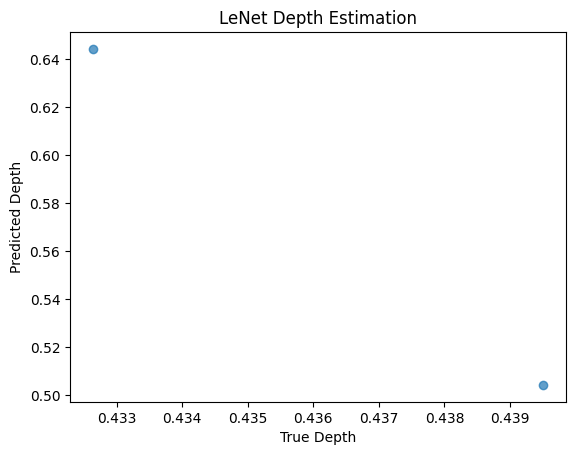

Training CNN...
Epoch 1/10


c:\Users\islas\OneDrive\Documents\GitHub\deep_learning_proj\.conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5.6812 - mae: 2.0879 - val_loss: 28.6132 - val_mae: 4.9718
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 169458.6719 - mae: 389.6654 - val_loss: 1.8638 - val_mae: 1.0213
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 13166.1670 - mae: 86.4297 - val_loss: 0.8897 - val_mae: 0.8460
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 23181.3906 - mae: 145.1888 - val_loss: 1.6856 - val_mae: 1.2971
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 21293.2676 - mae: 127.8358 - val_loss: 3.8850 - val_mae: 1.7387
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 14648.8945 - mae: 116.3044 - val_loss: 4.7211 - val_mae: 1.9958
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - loss: 4889.6709 - mae: 52.2992 - val_loss: 4.4170 - val_mae: 1.9989
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 23515.9941 - mae: 122.2237 - val_loss: 2.4118 - val_mae: 1.5341
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/

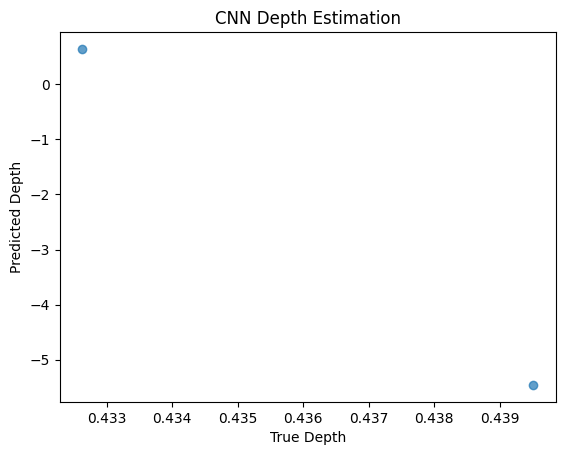

Training ResNet...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step - loss: 0.2345 - mae: 0.3974 - val_loss: 12.2102 - val_mae: 3.4943
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step - loss: 12.5333 - mae: 2.8994 - val_loss: 6.6760 - val_mae: 2.5838
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - loss: 25.3057 - mae: 4.8242 - val_loss: 3.3118 - val_mae: 1.8197
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step - loss: 14.3130 - mae: 2.7768 - val_loss: 2.4570 - val_mae: 1.5675
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - loss: 5.7639 - mae: 1.5709 - val_loss: 0.0224 - val_mae: 0.1496
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - loss: 0.2008 - mae: 0.3429 - val_loss: 3.7768 - val_mae: 1.9434
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step - loss: 3.6610 - mae: 1.2635 - val_loss: 6.5307 - val_mae: 2.5555
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step - loss: 0.7949 - mae: 0.7248 - val_loss: 290.6223 - val_mae: 17.0476
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/st

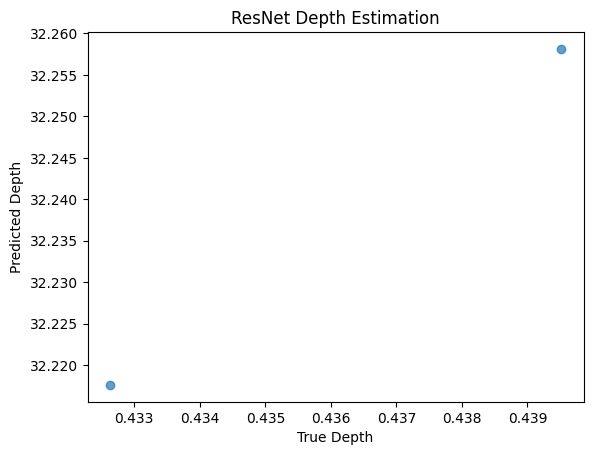

In [51]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# LeNet Regression
def create_lenet_regression(input_shape):
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# CNN Regression
def create_cnn_regression(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# ResNet Regression
def create_resnet_regression(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

#training + evaluting regressions
def train_and_evaluate_regression(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    print(f"Training {model_name}...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=16,
                        validation_data=(X_val, y_val), verbose=1)
    y_pred = model.predict(X_test).flatten()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} RMSE: {rmse:.2f}")
    

    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("True Depth")
    plt.ylabel("Predicted Depth")
    plt.title(f"{model_name} Depth Estimation")
    plt.show()
    return history


lenet_model_reg = create_lenet_regression(input_shape)
lenet_history_reg = train_and_evaluate_regression(lenet_model_reg, "LeNet", X_train, y_train[:, 1], X_val, y_val[:, 1], X_test, y_test[:, 1])

cnn_model_reg = create_cnn_regression(input_shape)
cnn_history_reg = train_and_evaluate_regression(cnn_model_reg, "CNN", X_train, y_train[:, 1], X_val, y_val[:, 1], X_test, y_test[:, 1])

resnet_model_reg = create_resnet_regression(input_shape)
resnet_history_reg = train_and_evaluate_regression(resnet_model_reg, "ResNet", X_train, y_train[:, 1], X_val, y_val[:, 1], X_test, y_test[:, 1])
